In [1]:
import os
import numpy as np
import tensorflow as tf
from keras import optimizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from segnet import segnet
from generator import DataGenerator

Using TensorFlow backend.


In [2]:
# hyperparameters
nv=int(2**16) # variants
na=2          # alleles
nc=7          # ancestry classes
ne=100        # number of epochs
nf=16         # number of segnet filters
fs=8          # filter size
bs=32         # batch size
gen=True      # use data generator
hor=False     # use multi-gpu
oce=True      # include oceanian samples
dev=True      # do we have a dev set

# reproducibility
# np.random.seed(23910464)
np.random.seed(1)

In [3]:
# configure horovod if we're using multiple gpus
# - note that this doesn't work within a jupyter notebook
# - but you can use it to assign one of the two gpus to the tf instance
# - ((probably))
if hor: 
    import horovod.keras as hvd 

    # initialize horovod instance -- this currently only works on galangal
    hvd.init()

    # assign GPUs to horovod 
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    if gpus:
        # tf.config in tf <= 1.6
        tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')
    print(gpus)

In [4]:
# sanity check that we're on gpu -- use #1
os.environ["CUDA_VISIBLE_DEVICES"]="1"
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# declare model
model=segnet(input_shape=(nv, na), n_classes=nc-1+int(oce), n_filters=nf, width=fs)

# and optimizer
if hor:
    adam=optimizers.Adam(lr=1e-5 * hvd.size())
    adam=hvd.DistributedOptimizer(adam)
else:
    adam=optimizers.Adam(lr=1e-4)

# now compile and show parameter summary
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 
print(model.summary())

Model: "segnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 65536, 2)     0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 65536, 2)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_down1 (Conv1D)            (None, 65536, 16)    272         dropout_1[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 65536, 16)    0           conv1_down1[0][0]                
_____________________________________________________________________________________________

In [6]:
# load data
data_root='/home/magu/deepmix/data/reference_panel/'
X = np.load(data_root+'unzipped/panel_chr20.G.npy', mmap_mode='r')
Y = np.load(data_root+'unzipped/panel_chr20.L.npy', mmap_mode='r')
S = np.load(data_root+'unzipped/panel_chr20.S.npy')
print([X.shape, Y.shape, X.shape])

[(2764, 516801, 2), (2764, 516801, 7), (2764, 516801, 2)]


In [7]:
# and train individuals
train=np.loadtxt('../data/reference-panel/split/train.strands.txt', dtype=str)
train_ix=[i for i,q in enumerate(S) if q in train]
np.random.shuffle(train_ix)
print(len(train_ix))

2090


In [8]:
# and some dev individuals, why not -- first pick their indexes
if dev:
    #n=100
    S=np.load(data_root+'simulated_chr20/label/dev_10gen.result.npz')['S']
    s=S#np.random.choice(S, size=min(n, S.shape[0]), replace=False)

    # then load and subset -- AMR is the first ancestry label, ignored for now
    x_f=data_root+'simulated_chr20/numpy/dev_10gen.query.npz'
    y_f=data_root+'simulated_chr20/label/dev_10gen.result.npz'
    S_f=np.load(x_f)['S']
    X_dev=np.load(x_f)['G'][[np.where(S_f==(i))[0][0] for i in s],:nv,:na]
    S_f=np.load(y_f)['S']
    Y_dev=to_categorical(np.load(y_f)['L'][[np.where(S_f==(i))[0][0] for i in s],:nv], dtype='bool')[:,:,1:]
    print([X_dev.shape, Y_dev.shape])

[(200, 65536, 2), (200, 65536, 7)]


In [9]:
# now try it out!
if not oce:
    train_ix=[i for i in train_ix if Y[i,0,:].dot(np.arange(nc))!=4]
    Y=Y[:,:,[i for i in range(nc) if i!=4]]
if dev:
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25) # not implemented below

    # fit with generator, or not
    if gen:
        params={'X':X, 'Y':Y, 'dim':nv, 'batch_size':bs, 'n_classes':nc, 'n_alleles':na}
        generator=DataGenerator(train_ix, **params)
        history=model.fit_generator(generator=generator, epochs=ne, validation_data=(X_dev, Y_dev), callbacks=[es])
    else:
        history=model.fit(X[train_ix,:nv,:na], Y[train_ix,:nv,:], batch_size=bs, epochs=ne, 
                           validation_data=(X_dev, Y_dev), callbacks=[es])
else:
    history=model.fit(X[train_ix,:nv,:na], Y[train_ix,:nv,:], batch_size=bs, epochs=ne)

Epoch 1/100
65/65 [==============================] - 169s 3s/step - loss: 1.7802 - accuracy: 0.3049 - val_loss: 1.5438 - val_accuracy: 0.3846
Epoch 2/100
65/65 [==============================] - 103s 2s/step - loss: 1.6405 - accuracy: 0.3561 - val_loss: 1.5355 - val_accuracy: 0.3854
Epoch 3/100
65/65 [==============================] - 103s 2s/step - loss: 1.6136 - accuracy: 0.3618 - val_loss: 1.5314 - val_accuracy: 0.3979
Epoch 4/100
65/65 [==============================] - 103s 2s/step - loss: 1.5750 - accuracy: 0.3999 - val_loss: 1.4882 - val_accuracy: 0.4627
Epoch 5/100
65/65 [==============================] - 103s 2s/step - loss: 1.5063 - accuracy: 0.4449 - val_loss: 1.3864 - val_accuracy: 0.5201
Epoch 6/100
65/65 [==============================] - 103s 2s/step - loss: 1.4480 - accuracy: 0.4745 - val_loss: 1.3372 - val_accuracy: 0.5222
Epoch 7/100
65/65 [==============================] - 103s 2s/step - loss: 1.3994 - accuracy: 0.5001 - val_loss: 1.2805 - val_accuracy: 0.5476
Epoch 

65/65 [==============================] - 104s 2s/step - loss: 0.1524 - accuracy: 0.9480 - val_loss: 0.4019 - val_accuracy: 0.9172
Epoch 59/100
65/65 [==============================] - 104s 2s/step - loss: 0.1458 - accuracy: 0.9509 - val_loss: 0.4246 - val_accuracy: 0.9102
Epoch 60/100
65/65 [==============================] - 105s 2s/step - loss: 0.1384 - accuracy: 0.9536 - val_loss: 0.4037 - val_accuracy: 0.9197
Epoch 61/100
65/65 [==============================] - 104s 2s/step - loss: 0.1520 - accuracy: 0.9484 - val_loss: 0.3813 - val_accuracy: 0.9136
Epoch 62/100
65/65 [==============================] - 104s 2s/step - loss: 0.1292 - accuracy: 0.9566 - val_loss: 0.4033 - val_accuracy: 0.9181
Epoch 63/100
65/65 [==============================] - 104s 2s/step - loss: 0.1275 - accuracy: 0.9567 - val_loss: 0.3988 - val_accuracy: 0.9153
Epoch 64/100
65/65 [==============================] - 104s 2s/step - loss: 0.1073 - accuracy: 0.9638 - val_loss: 0.4290 - val_accuracy: 0.9217
Epoch 65/100

In [10]:
# save
model.save('chm20_short.h5')

0.9336029291152954


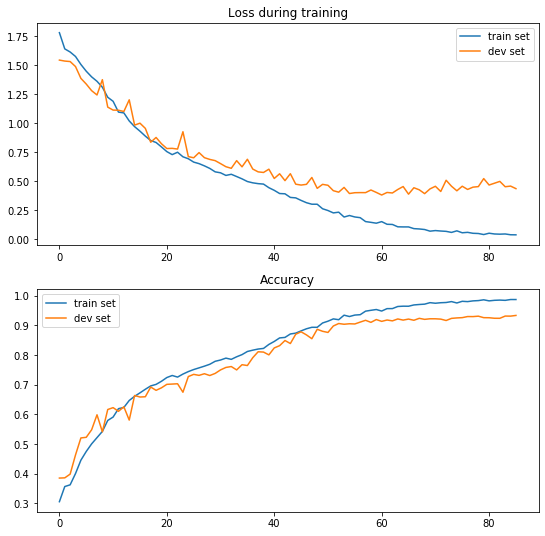

In [11]:
_, dev_acc = model.evaluate(X_dev, Y_dev, verbose=0)

# 1.1) plot loss during training
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1, (9,9))
plt.subplot(211)
plt.title('Loss during training')
plt.plot(history.history['loss'], label='train set')
plt.plot(history.history['val_loss'], label='dev set')
plt.legend()

# 1.2) plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train set')
plt.plot(history.history['val_accuracy'], label='dev set')
plt.legend()

print(dev_acc)

In [12]:
Y_hat_p=model.predict(X_dev)
Y_hat=np.argmax(Y_hat_p, axis=-1)

In [13]:
Y_hat.shape

(200, 65536)

In [14]:
Y.sum(axis=0).sum(axis=0)/Y.sum().sum().sum()

array([0.276411  , 0.36324168, 0.1121563 , 0.05499276, 0.01447178,
       0.13096961, 0.04775687])

In [15]:
Y_dev.sum(axis=0).sum(axis=0)/Y_dev.sum().sum().sum()

array([3.06760101e-01, 3.85397873e-01, 4.85302734e-02, 1.05390320e-01,
       2.27355957e-04, 1.26889343e-01, 2.68047333e-02])

In [16]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [17]:
pd.DataFrame(confusion_matrix(Y_dev.dot(np.arange(nc)).flatten(), Y_hat.flatten())/(Y_hat.shape[0]*Y_hat.shape[1]), 
             columns=['AFR','EAS','EUR','NAT','OCE','SAS','WAS'], index=['AFR','EAS','EUR','NAT','OCE','SAS','WAS'])

,AFR,EAS,EUR,NAT,OCE,SAS,WAS
AFR,0.298764,0.003085,0.000075,0.000040,0.000414,0.003939,0.000443
EAS,0.005147,0.368309,0.000246,0.002592,0.000356,0.008561,0.000188
EUR,0.000936,0.002122,0.034059,0.000545,0.000057,0.010219,0.000592
NAT,0.000424,0.003464,0.001706,0.097582,0.000000,0.002112,0.000102
OCE,0.000000,0.000227,0.000000,0.000000,0.000000,0.000000,0.000000
SAS,0.002029,0.005973,0.004123,0.000421,0.000053,0.114059,0.000232
WAS,0.002709,0.000516,0.001015,0.000044,0.000037,0.001653,0.020830


In [18]:
for i in range(Y_hat.shape[0]):
    print((i, [np.count_nonzero(Y_hat[i,:]==j) for j in range(Y_hat_p.shape[-1])], 
           [np.count_nonzero(Y_dev[i,:,:].argmax(axis=-1)==j) for j in range(Y_hat_p.shape[-1])]))

(0, [21934, 35237, 0, 0, 0, 8365, 0], [21456, 34228, 1571, 0, 0, 8281, 0])
(1, [0, 65536, 0, 0, 0, 0, 0], [0, 65536, 0, 0, 0, 0, 0])
(2, [58505, 7031, 0, 0, 0, 0, 0], [56967, 8569, 0, 0, 0, 0, 0])
(3, [0, 65536, 0, 0, 0, 0, 0], [0, 65536, 0, 0, 0, 0, 0])
(4, [0, 65536, 0, 0, 0, 0, 0], [0, 65536, 0, 0, 0, 0, 0])
(5, [0, 20178, 2, 45354, 0, 2, 0], [0, 18875, 0, 46661, 0, 0, 0])
(6, [36154, 0, 212, 28382, 0, 614, 174], [36154, 0, 0, 29382, 0, 0, 0])
(7, [65536, 0, 0, 0, 0, 0, 0], [65536, 0, 0, 0, 0, 0, 0])
(8, [0, 42601, 0, 2, 0, 22933, 0], [0, 42680, 0, 0, 0, 22856, 0])
(9, [65536, 0, 0, 0, 0, 0, 0], [65536, 0, 0, 0, 0, 0, 0])
(10, [44551, 0, 5273, 0, 93, 12369, 3250], [45017, 0, 9300, 0, 0, 11219, 0])
(11, [15876, 29313, 403, 0, 0, 14605, 5339], [11343, 28576, 0, 0, 0, 13851, 11766])
(12, [29900, 20741, 0, 0, 0, 14895, 0], [27835, 23850, 0, 0, 0, 13851, 0])
(13, [0, 62813, 0, 2723, 0, 0, 0], [0, 65536, 0, 0, 0, 0, 0])
(14, [0, 62124, 13, 158, 0, 3241, 0], [1880, 63656, 0, 0, 0, 0, 0])
(

(126, [16080, 49307, 0, 0, 0, 149, 0], [16456, 49080, 0, 0, 0, 0, 0])
(127, [0, 65134, 0, 0, 0, 402, 0], [0, 65536, 0, 0, 0, 0, 0])
(128, [8878, 40045, 0, 11573, 129, 4911, 0], [9112, 43984, 0, 12440, 0, 0, 0])
(129, [6714, 46292, 668, 0, 0, 11862, 0], [2792, 47035, 0, 0, 0, 15709, 0])
(130, [45552, 1, 842, 16716, 1286, 1065, 74], [47557, 0, 0, 17979, 0, 0, 0])
(131, [0, 6794, 38556, 18237, 0, 1949, 0], [0, 5751, 42107, 17678, 0, 0, 0])
(132, [0, 6794, 38556, 18237, 0, 1949, 0], [0, 5751, 42107, 17678, 0, 0, 0])
(133, [0, 35237, 0, 0, 0, 30299, 0], [0, 34228, 0, 0, 0, 31308, 0])
(134, [0, 35237, 0, 0, 0, 30299, 0], [0, 34228, 0, 0, 0, 31308, 0])
(135, [0, 31088, 5412, 0, 0, 29036, 0], [0, 29863, 15096, 0, 0, 20577, 0])
(136, [0, 65536, 0, 0, 0, 0, 0], [0, 65536, 0, 0, 0, 0, 0])
(137, [57335, 0, 2, 6702, 0, 1334, 163], [57128, 0, 0, 8408, 0, 0, 0])
(138, [57335, 0, 2, 6702, 0, 1334, 163], [57128, 0, 0, 8408, 0, 0, 0])
(139, [28217, 29973, 2571, 0, 0, 4597, 178], [28893, 30032, 0, 0, 0, 

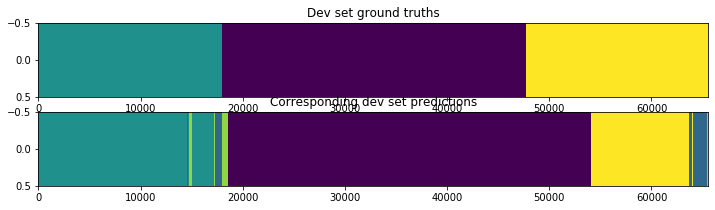

In [19]:
plt.figure(figsize=(12, 3))
Y_dev_lab = np.argmax(Y_dev, axis=-1)
plt.subplot(211)
plt.title('Dev set ground truths')
plt.imshow(Y_dev_lab[48:49,:].astype(int), aspect='auto')#, cmap='jet')

plt.subplot(212)
plt.title('Corresponding dev set predictions')
plt.imshow(Y_hat[48:49,:].astype(int), aspect='auto')#, cmap='jet')

In [20]:
np.where(np.argmax(Y_hat_p[48,:,:], axis=-1)==3)

(array([    3,     4,     5, ..., 17180, 17181, 65535]),)

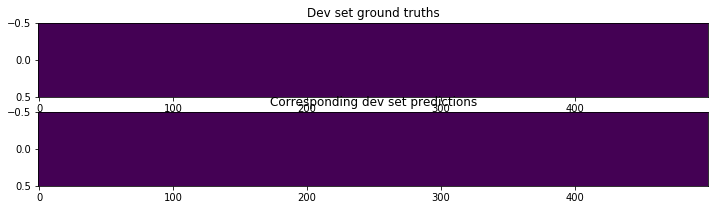

In [21]:
plt.figure(figsize=(12, 3))
Y_dev_lab = np.argmax(Y_dev, axis=-1)
plt.subplot(211)
plt.title('Dev set ground truths')
plt.imshow(Y_dev_lab[48:49,29000:29500].astype(int), aspect='auto')#, cmap='jet')

plt.subplot(212)
plt.title('Corresponding dev set predictions')
plt.imshow(Y_hat[48:49,29000:29500].astype(int), aspect='auto')#, cmap='jet')

In [22]:
Y_hat_p[48,np.where(np.argmax(Y_hat_p[48,:,:], axis=-1)==3),:]

array([[[1.29923850e-04, 1.24904290e-01, 3.16251069e-01, ...,
         4.03305661e-04, 1.46978544e-02, 2.41918173e-02],
        [2.32746879e-05, 6.93751425e-02, 3.52999270e-01, ...,
         1.17804295e-04, 1.08935377e-02, 1.60564873e-02],
        [5.18488969e-06, 4.15723175e-02, 2.26749063e-01, ...,
         2.75212424e-05, 8.30342341e-03, 1.15948897e-02],
        ...,
        [3.19781925e-08, 9.54711437e-03, 8.20325688e-02, ...,
         5.03841011e-06, 4.52177435e-01, 8.87516595e-04],
        [4.10397831e-08, 1.04052657e-02, 7.98047110e-02, ...,
         4.85757710e-06, 4.31869954e-01, 9.48413683e-04],
        [1.85551085e-02, 2.36036152e-01, 1.40845597e-01, ...,
         1.59436986e-02, 1.25866130e-01, 9.28995758e-02]]], dtype=float32)

In [23]:
# seems like a crf-smoother (even a post-hoc one) could really help